Summary 



In [57]:

import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import requests
from pprint import pprint
from scipy.optimize import curve_fit
import random
import datetime
import seaborn as sns
from tqdm import tqdm 
from scipy.stats import linregress

# Import the OpenWeatherMap API key
from api_keys_2 import weather_api_key
from api_keys_2 import geoapify_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

geoapify_key = "500fc220fff440468fe84e5b1d9b4adb"



In [58]:
#File Path and read filepath and store into pandas DataFrames

file = os.path.join("Resources","us_counties_covid19_daily.csv")

C19_df = pd.read_csv(file, encoding="ISO-8859-1")
C19_df.head(10)


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0
5,2020-01-25,Orange,California,6059.0,1,0.0
6,2020-01-25,Cook,Illinois,17031.0,1,0.0
7,2020-01-25,Snohomish,Washington,53061.0,1,0.0
8,2020-01-26,Maricopa,Arizona,4013.0,1,0.0
9,2020-01-26,Los Angeles,California,6037.0,1,0.0


In [4]:

covid_df = C19_df
covid_df['combined'] = covid_df['county'] + "," + covid_df['state']
covid_df.head(5)

,date,county,state,fips,cases,deaths,combined
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,"Snohomish,Washington"
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,"Snohomish,Washington"
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,"Snohomish,Washington"
3,2020-01-24,Cook,Illinois,17031.0,1,0.0,"Cook,Illinois"
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0,"Snohomish,Washington"


In [5]:
# Select rows in my date range
# Make a start and end date
Beg_date = '2020-06-01'

# Make an end date
end_date = '2020-08-31'

# Select DataFrame rows between two dates
mask = (covid_df['date'] > Beg_date) & (C19_df['date'] <= end_date)
summer_covid_df = covid_df.loc[mask]

summer_covid_df.head()

,date,county,state,fips,cases,deaths,combined
199923,2020-06-02,Autauga,Alabama,1001.0,240,5.0,"Autauga,Alabama"
199924,2020-06-02,Baldwin,Alabama,1003.0,308,9.0,"Baldwin,Alabama"
199925,2020-06-02,Barbour,Alabama,1005.0,176,1.0,"Barbour,Alabama"
199926,2020-06-02,Bibb,Alabama,1007.0,79,1.0,"Bibb,Alabama"
199927,2020-06-02,Blount,Alabama,1009.0,65,1.0,"Blount,Alabama"


In [9]:
# Sort by date and reset index
summer_covid_df=  summer_covid_df.sort_values('date')
summer_covid_df = summer_covid_df.reset_index(drop=True)

summer_covid_df.head()


,date,county,state,fips,cases,deaths,combined
0,2020-06-02,Autauga,Alabama,1001.0,240,5.0,"Autauga,Alabama"
1,2020-06-02,St. Charles,Missouri,29183.0,799,61.0,"St. Charles,Missouri"
2,2020-06-02,Baldwin,Alabama,1003.0,308,9.0,"Baldwin,Alabama"
3,2020-06-02,Barbour,Alabama,1005.0,176,1.0,"Barbour,Alabama"
4,2020-06-02,Bibb,Alabama,1007.0,79,1.0,"Bibb,Alabama"


In [8]:
# Organize the data by grouping by counties and calculating the total cases
county_cases_df = summer_covid_df.groupby(['county']).agg({'cases': 'sum'})

county_cases_df.head(10)

,cases
county,
Abbeville,19184
Acadia,149844
Accomack,96320
Ada,494759
Adair,49039
Adams,655195
Addison,6420
Adjuntas,6350
Aguada,7804


In [13]:
summer_covid_df['year'] = summer_covid_df['date'].str[:4]
summer_covid_df

,date,county,state,fips,cases,deaths,combined,year
0,2020-06-02,Autauga,Alabama,1001.0,240,5.0,"Autauga,Alabama",2020
1,2020-06-02,St. Charles,Missouri,29183.0,799,61.0,"St. Charles,Missouri",2020
2,2020-06-02,Baldwin,Alabama,1003.0,308,9.0,"Baldwin,Alabama",2020
3,2020-06-02,Barbour,Alabama,1005.0,176,1.0,"Barbour,Alabama",2020
4,2020-06-02,Bibb,Alabama,1007.0,79,1.0,"Bibb,Alabama",2020
...,...,...,...,...,...,...,...,...
289268,2020-08-31,Albany,Wyoming,56001.0,134,0.0,"Albany,Wyoming",2020
289269,2020-08-31,Wood,Wisconsin,55141.0,458,2.0,"Wood,Wisconsin",2020
289270,2020-08-31,Winnebago,Wisconsin,55139.0,1528,21.0,"Winnebago,Wisconsin",2020
289271,2020-08-31,Park,Wyoming,56029.0,164,0.0,"Park,Wyoming",2020


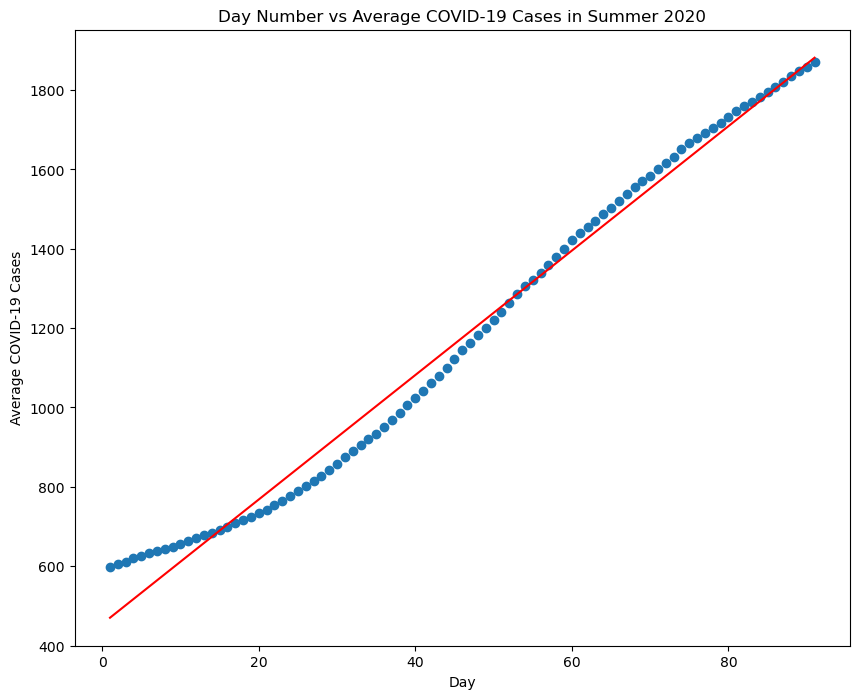

In [18]:
#Create scatter plot of day number vs. average COVID-19 cases for summer
day_number = [i+1 for i in range(summer_covid_df['date'].nunique())]
avg_cases = summer_covid_df.groupby(['date']).agg({'cases': 'mean'})
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(day_number, avg_cases) 
plt.xlabel('Day')
plt.ylabel('Average COVID-19 Cases')
plt.title('Day Number vs Average COVID-19 Cases in Summer 2020')

# Calculate the line of best fit using linear regression
x = np.array(day_number)
y = np.array(avg_cases['cases'])
line = np.polyfit(x, y, 1)
plt.plot(x, line[0]*x + line[1], color='red')

# Calculate the r-squared value
r_squared = np.corrcoef(x, y)[0, 1] ** 2

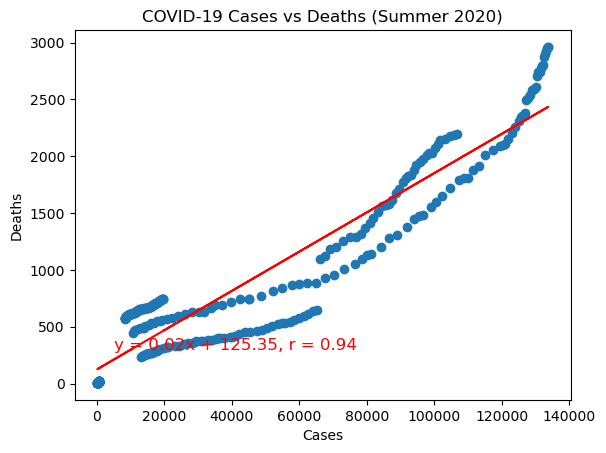

In [39]:
# Build scatter plot for avg cases vs death in 2020
slope, intercept, r_value, p_value, std_err = linregress(summer_covid_df['cases'], summer_covid_df['deaths'])
line = slope * summer_covid_df['cases'] + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}, r = {r_value:.2f}"
plt.scatter(summer_covid_df['cases'], summer_covid_df['deaths'])
plt.plot(summer_covid_df['cases'], line, color='red')
plt.annotate(line_eq, (5000, 300), fontsize=12, color='red')
plt.xlabel('Cases')
plt.ylabel('Deaths')
plt.title('COVID-19 Cases vs Deaths (Summer 2020)')
plt.show()


In [47]:
# Exponential regression on COVID-19 cases

# Define the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Define x and y values
x = np.array(range(1, len(summer_covid_df)+1))
y = summer_covid_df['cases'].values

# Fit the exponential function to the data
popt, pcov = curve_fit(exponential_func, x, y)

# Get the parameters of the exponential function
a = popt[0]
b = popt[1]
c = popt[2]

# Calculate the R-squared value
residuals = y - exponential_func(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# Print the equation of the exponential function and the R-squared value
print(f"Exponential function: y = {a:.2f} * e^({-b:.6f}x) + {c:.2f}")
print(f"R-squared: {r_squared:.4f}")

# Plot the data and the exponential function
plt.plot(x, y, label='Actual data')
plt.plot(x, exponential_func(x, *popt), 'r-', label='Exponential fit')
plt.legend()
plt.title('COVID-19 Cases Exponential Regression')
plt.xlabel('Day')
plt.ylabel('COVID-19 Cases')
plt.show()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [48]:
# Create a pie chart of the total cases by county
#fig, ax = plt.subplots(figsize=(10, 8))
#ax.pie(county_cases_df['cases'], labels=county_cases_df.index, autopct='%1.1f%%', startangle=90)
#ax.axis('equal')
#plt.title('Percentage of Total COVID-19 Cases by County in Summer 2020')


In [50]:
selected_counties = ['Harris', 'Maricopa', 'King'] 

random_covid_df = summer_covid_df[summer_covid_df['county'].isin(selected_counties)]
random_covid_df


,date,county,state,fips,cases,deaths,combined,year
95,2020-06-02,Maricopa,Arizona,4013.0,10536,448.0,"Maricopa,Arizona",2020
446,2020-06-02,Harris,Georgia,13145.0,102,6.0,"Harris,Georgia",2020
2576,2020-06-02,Harris,Texas,48201.0,13027,236.0,"Harris,Texas",2020
2904,2020-06-02,King,Washington,53033.0,8237,572.0,"King,Washington",2020
3239,2020-06-03,Maricopa,Arizona,4013.0,11068,466.0,"Maricopa,Arizona",2020
...,...,...,...,...,...,...,...,...
285864,2020-08-30,King,Washington,53033.0,19573,742.0,"King,Washington",2020
286140,2020-08-31,Maricopa,Arizona,4013.0,133728,2961.0,"Maricopa,Arizona",2020
286495,2020-08-31,Harris,Georgia,13145.0,725,21.0,"Harris,Georgia",2020
288747,2020-08-31,Harris,Texas,48201.0,106595,2192.0,"Harris,Texas",2020


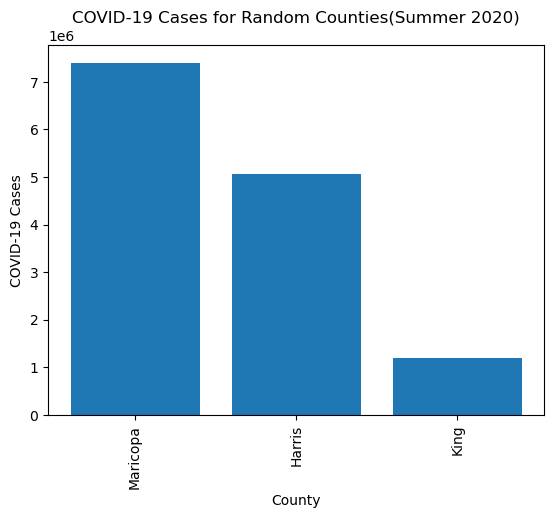

In [56]:
#Create bar graph of top COVID-19 cases in the selected Random Cities for summer
random_covid_df = random_covid_df.groupby('county')['cases'].sum().reset_index().sort_values('cases', ascending=False).head(10)
plt.bar(top_counties['county'], top_counties['cases'])
plt.xticks(rotation=90)
plt.xlabel('County')
plt.ylabel('COVID-19 Cases')
plt.title('COVID-19 Cases for Random Counties(Summer 2020)')
plt.show()


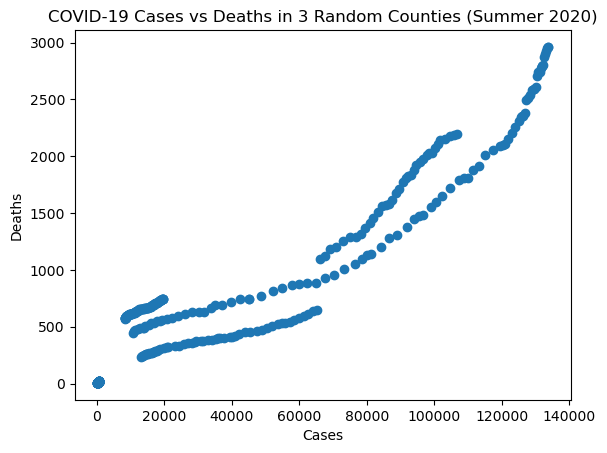

In [51]:
# Create scatter plot of cases vs deaths
plt.scatter(random_covid_df["cases"], random_covid_df["deaths"])
plt.xlabel("Cases")
plt.ylabel("Deaths")
plt.title('COVID-19 Cases vs Deaths in 3 Random Counties (Summer 2020)')
plt.show()


In [60]:


def get_weather_data(county, date):
    api_key = '0f981aa9f141936072443c28c825a912'
    base_url = 'https://api.openweathermap.org/data/3.0/onecall/timemachine?'
    

    # Specify the county and date for which you want weather data
    query_params = {
        'key': api_key,
        'q': county,
        'dt': date
    }

    # Make the API request
    response = requests.get(base_url, params=query_params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()

        # Extract the required weather data
        temp_c = data['forecast']['forecastday'][0]['day']['avgtemp_c']
        wind_kph = data['forecast']['forecastday'][0]['day']['maxwind_kph']
        humidity = data['forecast']['forecastday'][0]['day']['avghumidity']
        
        weather_data = {
            'temp_c': temp_c,
            'wind_kph': wind_kph,
            'humidity': humidity
        }
        
        return weather_data
    else:
        print('Error occurred while fetching weather data.')


In [63]:
weather_data_list = []

for county in tqdm(selected_counties, desc='Processing Counties'):
    county_data = summer_covid_df[summer_covid_df['county'] == county]
    
    for index, row in tqdm(county_data.iterrows(), desc=f'Processing {county}'):
        date = row['date']
        
        # Call the get_weather_data() function to retrieve weather data
        weather_data = get_weather_data(county, date)
        
        temperature = weather_data['temp_c']
        wind_speed = weather_data['wind_kph']
        humidity = weather_data['humidity']
        
        weather_data_list.append((county, date, temperature, wind_speed, humidity))

weather_df = pd.DataFrame(weather_data_list, columns=['County', 'Date', 'Temperature', 'Wind Speed', 'Humidity'])
summer_covid_df = summer_covid_df.merge(weather_df, left_on=['county', 'new_date'], right_on=['County', 'Date'])
summer_covid_df = summer_covid_df.drop(['County', 'Date'], axis=1)
summer_covid_df

Processing Counties:   0%|                                                                       | 0/3 [00:00<?, ?it/s]
Processing Harris: 0it [00:00, ?it/s]
Processing Counties:   0%|                                                                       | 0/3 [00:00<?, ?it/s]

Error occurred while fetching weather data.


TypeError: 'NoneType' object is not subscriptable